# MLP Model Evaluation

In [1]:
import yaml, glob
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from callbacks import get_callbacks 
import logging
from sklearn.utils import class_weight
from plotting import plot_confusion_matrix
from metrics import average_acc

2022-07-01 10:23:06.611459: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Build model and load saved weights

In [2]:
model_name = 'asos_070122'

# set seed
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

# load config file
config = f'{model_name}_config.yml'
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)

# load data
df = pd.read_parquet(conf['data_path'])
    
# model config
features = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
outputs = conf['outputvars']
n_splits = conf['trainer']['n_splits']
train_size1 = conf['trainer']['train_size1'] # sets test size
train_size2 = conf['trainer']['train_size2'] # sets valid size
seed = conf['trainer']['seed']
num_hidden_layers = conf['trainer']['num_hidden_layers']
hidden_size = conf['trainer']['hidden_size']
dropout_rate = conf['trainer']['dropout_rate']
batch_size = conf['trainer']['batch_size']
ra_weight = conf['trainer']['ra_weight']
sn_weight = conf['trainer']['sn_weight']
pl_weight = conf['trainer']['pl_weight']
fzra_weight = conf['trainer']['fzra_weight']
class_weights = {0:ra_weight, 1:sn_weight, 2:pl_weight, 3:fzra_weight}
learning_rate = conf['trainer']['learning_rate']
# metrics = conf['trainer']['metrics']
activation = conf['trainer']['activation']
run_eagerly = conf['trainer']['run_eagerly']
shuffle = conf['trainer']['shuffle']
epochs = conf['trainer']['epochs']
label_smoothing = conf['trainer']['label_smoothing']
    
#split and preprocess the data
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size1, random_state=seed)
train_idx, test_idx = list(splitter.split(df, groups=df['day']))[0]
train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size2, random_state=seed)
train_idx, valid_idx = list(splitter.split(train_data, groups=train_data['day']))[0]
train_data, valid_data = train_data.iloc[train_idx], train_data.iloc[valid_idx]
    
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(train_data[features])
x_valid = scaler_x.transform(valid_data[features])
x_test = scaler_x.transform(test_data[features])
y_train = train_data[outputs].to_numpy()
y_valid = valid_data[outputs].to_numpy()
y_test = test_data[outputs].to_numpy()
    
def build_model(input_size, hidden_size, num_hidden_layers, output_size):
    model = tf.keras.models.Sequential()
        
    if activation == 'leaky':
        model.add(tf.keras.layers.Dense(input_size))
        model.add(tf.keras.layers.LeakyReLU())
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
            else:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
                model.add(tf.keras.layers.Dropout(dropout_rate))
    else:
        model.add(tf.keras.layers.Dense(input_size, activation=activation))
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
            else:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
                model.add(tf.keras.layers.Dropout(dropout_rate))
        
    model.add(tf.keras.layers.Dense(output_size, activation='softmax'))
    
    return model
    
model = build_model(len(features), hidden_size, num_hidden_layers, len(outputs))
model.build((batch_size, len(features)))
model.summary()

model.load_weights('/glade/work/jwillson/asos_opt_070122.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (34582, 268)              72092     
                                                                 
 dense_1 (Dense)             (34582, 534)              143646    
                                                                 
 dropout (Dropout)           (34582, 534)              0         
                                                                 
 dense_2 (Dense)             (34582, 534)              285690    
                                                                 
 dropout_1 (Dropout)         (34582, 534)              0         
                                                                 
 dense_3 (Dense)             (34582, 534)              285690    
                                                                 
 dropout_2 (Dropout)         (34582, 534)              0

2022-07-01 10:24:47.474491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/apps/dav/opt/ucx/1.11.0/lib:/glade/u/apps/opt/intel/2020u1/compilers_and_libraries/linux/lib/intel64
2022-07-01 10:24:47.474523: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-01 10:24:47.475354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is opt

### Predict on test set using saved model

In [3]:
predictions = model.predict(x_test)

preds = np.argmax(predictions, 1)
labels = np.argmax(y_test, 1)
print((preds == labels).mean())
print(average_acc(y_test, predictions))

13051/13051 [==============================] - 19s 1ms/step
0.9112233340756332
0.7809483631221095


### Confusion Matrices

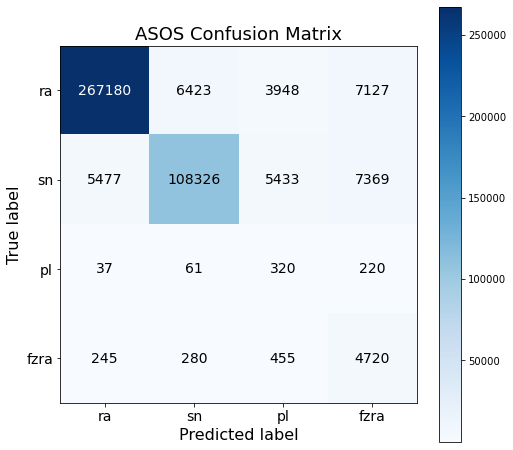

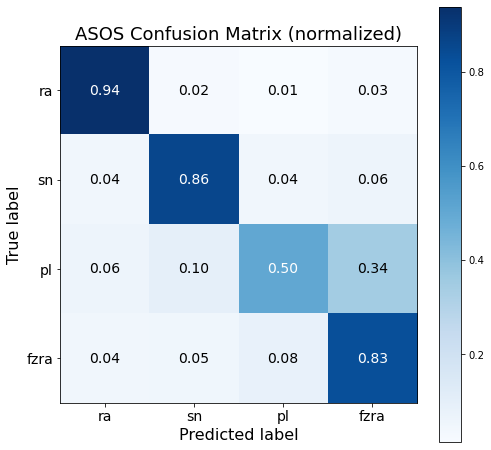

In [7]:
np.set_printoptions(precision=2)
class_names = ['ra', 'sn', 'pl', 'fzra']

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names,
                      title='ASOS Confusion Matrix', filename=f'{model_name}.png')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names, normalize=True,
                      title='ASOS Confusion Matrix (normalized)', filename=f'{model_name}_norm.png')

plt.show()